# Model 1: Logistic Regression

* LogReg and combinations of feature selection, nested y classes
* timeseriessplit for train/test split and cross validation, given sequenced data

In [1]:
from dotenv import load_dotenv
import sys
import warnings
from itertools import product

from __init__ import get_base_path
import data.load_data as load_data
import models.model_utils as models

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, \
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report, \
    roc_curve, RocCurveDisplay

import numpy as np
import os
import pandas as pd
from pandas.api.types import is_numeric_dtype
from matplotlib import pyplot as plt
import seaborn as sns

load_dotenv()
warnings.filterwarnings('ignore')

In [2]:
random_state = int(os.getenv('RANDOM_SEED'))

# Load Data

In [3]:
csv_file = load_data.combined_csv

df = load_data.load_from_csv(csv_file)

pd.set_option('display.max_columns', df.shape[1])
pd.set_option('display.max_rows', df.shape[0])

(78288, 232)


# Training Loop

* iterate X, y feature combinations
* train, test, split - time series split given signal sequence
* scale and one-hot encode
* train
* evaluate


In [4]:
features = models.FeatureStore(df)

X_features = [['R1_Phase_A_power_wave'], features.R1_waves, features.R1_R2_waves] # features.all_power_waves
y_features = [features.y_binary, features.y_tertiary, features.y_broad_class, features.y_full_class]

In [5]:
# TRAINING WITH TIME SERIES CROSS VALIDATION
timecv = TimeSeriesSplit(n_splits=5)
clf = LogisticRegressionCV(cv=timecv, random_state=random_state)

exp = models.SK_Classification_Experiment(df, X_features, y_features, estimators=[clf])
exp.run_experiments()

# Evaluation - Classification Reports

* LogReg models consistently chose the dominant class. Classification reports show Class 1/Attack precision == model overall accuracy, while class 0 has 0 precision/recall across the board.

* The model stops doing this when detailed class options were introduced, as seen by new variance in precision / recall by class. However these models performed the worst - accuracy near 0.

### Binary Class Predictions

In [6]:
binary_predictions = [i for i in exp.experiment_scores if i['y_features'] == features.y_binary]

for i in binary_predictions:
    print(i['X_features'])
    print('Training Scores')
    print(i['training_classification_report'])
    print('Test Scores')
    print(i['test_classification_report'])

['R1_Phase_A_power_wave']
Training Scores
              precision    recall  f1-score   support

      attack       0.71      1.00      0.83     44279
  not attack       0.00      0.00      0.00     18352

    accuracy                           0.71     62631
   macro avg       0.35      0.50      0.41     62631
weighted avg       0.50      0.71      0.59     62631

Test Scores
              precision    recall  f1-score   support

      attack       0.72      1.00      0.84     11295
  not attack       0.00      0.00      0.00      4362

    accuracy                           0.72     15657
   macro avg       0.36      0.50      0.42     15657
weighted avg       0.52      0.72      0.60     15657

['R1_Phase_A_voltage_wave', 'R1_Phase_A_current_wave', 'R1_Phase_A_power_wave', 'R1_Phase_B_voltage_wave', 'R1_Phase_B_current_wave', 'R1_Phase_B_power_wave', 'R1_Phase_C_voltage_wave', 'R1_Phase_C_current_wave', 'R1_Phase_C_power_wave']
Training Scores
              precision    recall  f1-

### Tertiary Class Predictions

In [7]:
tertiary_predictions = [i for i in exp.experiment_scores if i['y_features'] == features.y_tertiary]

for i in tertiary_predictions:
    print(i['X_features'])
    print('Training Scores')
    print(i['training_classification_report'])
    print('Test Scores')
    print(i['test_classification_report'])

['R1_Phase_A_power_wave']
Training Scores
              precision    recall  f1-score   support

      attack       0.71      1.00      0.83     44279
     natural       0.00      0.00      0.00     14738
    no event       0.00      0.00      0.00      3614

    accuracy                           0.71     62631
   macro avg       0.24      0.33      0.28     62631
weighted avg       0.50      0.71      0.59     62631

Test Scores
              precision    recall  f1-score   support

      attack       0.72      1.00      0.84     11295
     natural       0.00      0.00      0.00      3571
    no event       0.00      0.00      0.00       791

    accuracy                           0.72     15657
   macro avg       0.24      0.33      0.28     15657
weighted avg       0.52      0.72      0.60     15657

['R1_Phase_A_voltage_wave', 'R1_Phase_A_current_wave', 'R1_Phase_A_power_wave', 'R1_Phase_B_voltage_wave', 'R1_Phase_B_current_wave', 'R1_Phase_B_power_wave', 'R1_Phase_C_voltage_wave'

### Broad Class Predictions

In [8]:
broad_class_predictions = [i for i in exp.experiment_scores if i['y_features'] == features.y_broad_class]

for i in broad_class_predictions:
    print(i['X_features'])
    print('Training Scores')
    print(i['training_classification_report'])
    print('Test Scores')
    print(i['test_classification_report'])

['R1_Phase_A_power_wave']
Training Scores
                     precision    recall  f1-score   support

       attack fault       0.43      1.00      0.60     26975
 attack maintenance       0.00      0.00      0.00      2632
  command injection       0.00      0.00      0.00      6790
     data injection       0.00      0.00      0.00      7882
      natural fault       0.00      0.00      0.00     12032
natural maintenance       0.00      0.00      0.00      2706
           no event       0.00      0.00      0.00      3614

           accuracy                           0.43     62631
          macro avg       0.06      0.14      0.09     62631
       weighted avg       0.19      0.43      0.26     62631

Test Scores
                     precision    recall  f1-score   support

       attack fault       0.46      1.00      0.63      7223
 attack maintenance       0.00      0.00      0.00       514
  command injection       0.00      0.00      0.00      1947
     data injection       0

### Full Class Predictions

In [9]:
full_class_predictions = [i for i in exp.experiment_scores if i['y_features'] == features.y_full_class]

for i in full_class_predictions:
    print(i['X_features'])
    print('Training Scores')
    print(i['training_classification_report'])
    print('Test Scores')
    print(i['test_classification_report'])

['R1_Phase_A_power_wave']
Training Scores
                                                              precision    recall  f1-score   support

                                     Command Injection to R1       0.00      0.00      0.00      1110
                                     Command Injection to R2       0.00      0.00      0.00      1090
                                     Command Injection to R3       0.00      0.00      0.00       994
                                     Command Injection to R4       0.00      0.00      0.00       968
                              Command injection to R1 and R2       0.00      0.00      0.00      1514
                              Command injection to R3 and R4       0.00      0.00      0.00      1114
                                     Fault from 10-19% on L1       0.00      0.00      0.00      1284
            Fault from 10-19% on L1 with R1 disabled & fault       0.00      0.00      0.00      1030
Fault from 10-19% on L1 with data injec

# Evaluation - Confusion Matrix
* Back to training dataset to diagnose low F1, confirm issue is selection on the dominant class


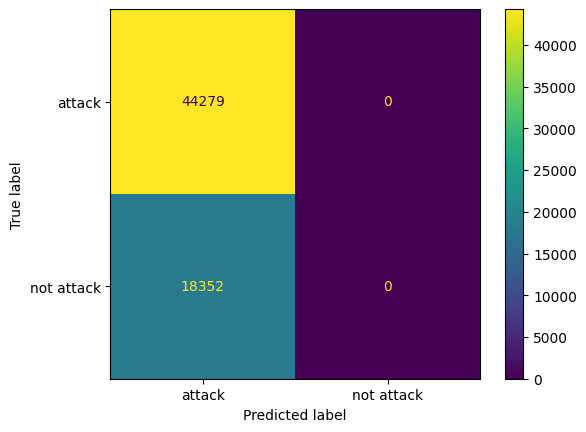

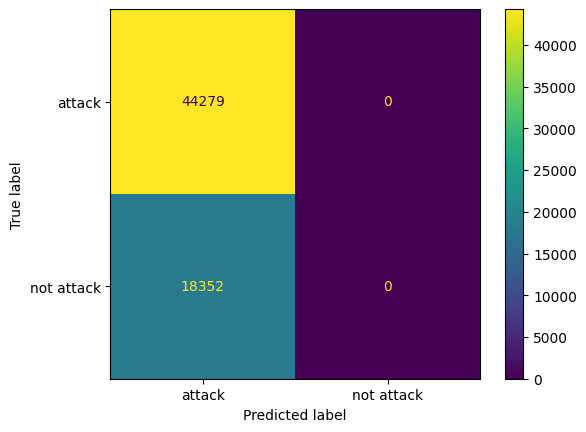

In [10]:
# binary example - 4th index is R1 wave features
y_true = exp.experiment_scores[4]['train_true']
y_pred = exp.experiment_scores[4]['train_pred']
labels = exp.experiment_scores[4]['y_classes']

disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
disp.plot()
plt.show()

# Evaluation - ROC

* Again, the TP vs FP rate is hugging 50% probability. It's basically flipping a coin.

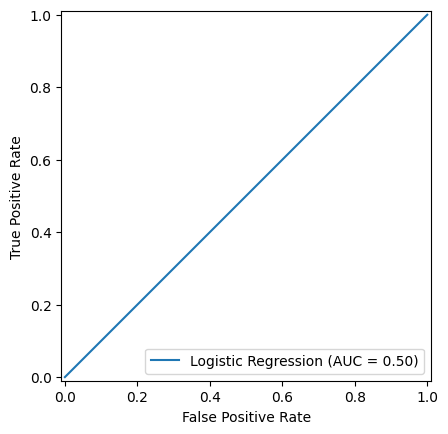

In [11]:
# binary example again
y_true = exp.experiment_scores[4]['train_true']
y_pred = exp.experiment_scores[4]['train_pred']
labels = exp.experiment_scores[4]['y_classes']

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
curve = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Logistic Regression')
curve.plot()
plt.show()

# Get Coefficients

Compare coefficients across the top and worst performing models.

* The binary model was 'best performing' model by metric but consistently selected the dominant class. Here, it doesn't assign any weight to any feature. It's failing to learn.

* The full class model with R1 & R2 features was among the worst performing experiments by metric. However since it exhibited more discrimenant activity, let's see it's coefficients. It is weighting moderate coefficients to current and voltage on R1 and R2, and penalizing power.

In [12]:
def plot_coeff(X_cols, clf):
    coeff = [(i, j) for i, j in zip(X_cols, np.round(clf.coef_.ravel(),2))]

    coeff = pd.DataFrame(coeff, columns=['feature','logit'], index=range(len(coeff)))
    coeff.sort_values(by='logit',ascending=False,inplace=True)

    # largest and smallest coeff
    top_coeff = coeff.head(8)
    bottom_coeff = coeff.tail(8)

    fig, ax = plt.subplots(2,1, figsize=(12.5,4))
   
    # plot top coeff
    g0 = ax[0].barh(top_coeff['feature'],top_coeff['logit'])
    ax[0].set_title('Top Features (Logit)')
    ax[0].bar_label(g0, fmt=lambda x: f'{x:.2f}')

    # plot bottom coeff
    g1 = ax[1].barh(bottom_coeff['feature'],bottom_coeff['logit'])
    ax[1].set_title('Bottom Features (Logit)')
    ax[1].bar_label(g1, fmt=lambda x: f'{x:.2f}')

    plt.tight_layout()
    plt.show()

    return coeff

['R1_Phase_A_voltage_wave', 'R1_Phase_A_current_wave', 'R1_Phase_A_power_wave', 'R1_Phase_B_voltage_wave', 'R1_Phase_B_current_wave', 'R1_Phase_B_power_wave', 'R1_Phase_C_voltage_wave', 'R1_Phase_C_current_wave', 'R1_Phase_C_power_wave']
is_attack


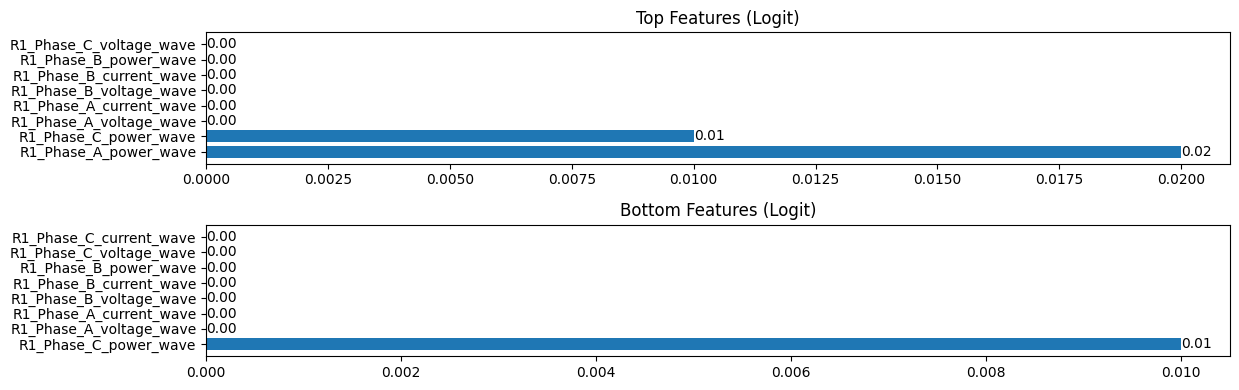

,feature,logit
2,R1_Phase_A_power_wave,0.02
8,R1_Phase_C_power_wave,0.01
0,R1_Phase_A_voltage_wave,0.00
1,R1_Phase_A_current_wave,0.00
3,R1_Phase_B_voltage_wave,0.00
4,R1_Phase_B_current_wave,-0.00
5,R1_Phase_B_power_wave,0.00
6,R1_Phase_C_voltage_wave,-0.00
7,R1_Phase_C_current_wave,0.00


In [13]:
# binary example - 4th index is R1 wave features
clf = exp.experiment_scores[4]['estimator']
X_features = exp.experiment_scores[4]['X_features']

print(X_features)
print(exp.experiment_scores[4]['y_features'])
plot_coeff(X_features, clf)

['R1_Phase_A_voltage_wave', 'R1_Phase_A_current_wave', 'R1_Phase_A_power_wave', 'R1_Phase_B_voltage_wave', 'R1_Phase_B_current_wave', 'R1_Phase_B_power_wave', 'R1_Phase_C_voltage_wave', 'R1_Phase_C_current_wave', 'R1_Phase_C_power_wave', 'R2_Phase_A_voltage_wave', 'R2_Phase_A_current_wave', 'R2_Phase_A_power_wave', 'R2_Phase_B_voltage_wave', 'R2_Phase_B_current_wave', 'R2_Phase_B_power_wave', 'R2_Phase_C_voltage_wave', 'R2_Phase_C_current_wave', 'R2_Phase_C_power_wave']
scenario_type


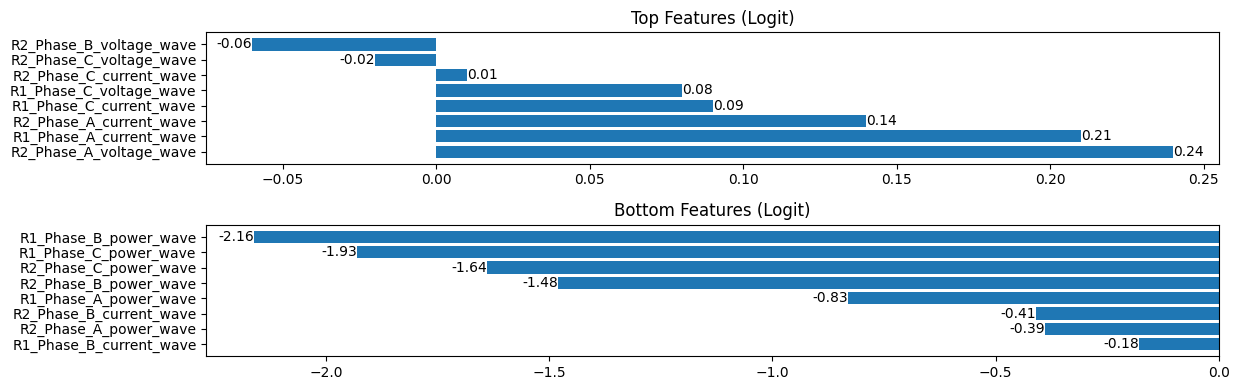

,feature,logit
9,R2_Phase_A_voltage_wave,0.24
1,R1_Phase_A_current_wave,0.21
10,R2_Phase_A_current_wave,0.14
7,R1_Phase_C_current_wave,0.09
6,R1_Phase_C_voltage_wave,0.08
16,R2_Phase_C_current_wave,0.01
15,R2_Phase_C_voltage_wave,-0.02
12,R2_Phase_B_voltage_wave,-0.06
3,R1_Phase_B_voltage_wave,-0.07
0,R1_Phase_A_voltage_wave,-0.11


In [14]:
# full class model - 11th index is R1R2 wave features
clf = exp.experiment_scores[11]['estimator']
X_features = exp.experiment_scores[11]['X_features']

print(X_features)
print(exp.experiment_scores[11]['y_features'])

plot_coeff(X_features, clf)